# CSE 518A - Final Project

## Table of Contents
1. [Constant](#Constant)
2. [Proportional](#Proportional)
3. [Parameters](#Parameters)
4. [Best setting](#Best-setting)
5. [Optimize](#Optimize)

In [74]:
import numpy as np
from scipy.stats import truncnorm
import seaborn as sns
import matplotlib.pyplot as plt

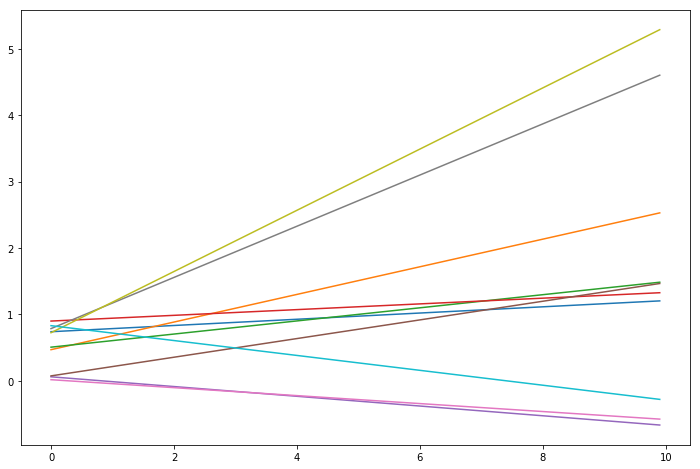

In [209]:
CONST = 0
PROP = 1
OPTIM = 2

num_item = 100
num_user = 10
num_step = 50
init_power = 100

np.random.seed(0)

funcs = np.zeros([num_user, 2])
funcs[:,0] = truncnorm.rvs(-0.5, 0.5, size=num_user)
funcs[:,1] = truncnorm.rvs(0, 1, size=num_user)

x = np.arange(0,10,0.1)
ys = np.zeros([num_user, len(x)])
for i in range(num_user):
    ys[i] = x * funcs[i,0] + funcs[i,1]
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
for i in range(num_user): ax.plot(x,ys[i])

In [198]:
def simulate(num_item, 
             num_user, 
             num_step, 
             init_power,  
             funcs,
             mechanism = CONST,
             a = None,
             b = None):
    new_ati = np.zeros([num_step, num_user])
    contrib = np.zeros([num_step, num_user])
    power = np.zeros([num_step+1, num_user])
    power[0] += init_power
    t = 0
    while t < num_step:
        if mechanism == CONST:
            new_ati[t] = np.minimum(num_item // num_step, num_item - np.sum(new_ati[:t],0))
        elif mechanism == PROP:
            if a == None: a = num_item // num_step
            if b == None: b = a*3
            ati = np.round(np.sum(contrib[:t],0) / np.sum(contrib) * b) if t != 0 else a
            new_ati[t] = np.minimum(ati, num_item - np.sum(new_ati[:t],0))
        elif mechanism == OPTIM:
            ati = np.zeros(num_user)
            ati[funcs[:,0] > 0] = 2
            new_ati[t] = np.minimum(ati, num_item - np.sum(new_ati[:t],0))
        con = new_ati[t] * funcs[:,0] + funcs[:,1]
        con = np.clip(con, 0, np.minimum(1, power[t]))
        contrib[t] = con
        power[t+1] = power[t] - con
        t += 1
    total = np.sum(contrib)
    steps = np.sum(power[1:] != 0)
    return new_ati, contrib, power, total, steps

In [ ]:
# if t == 0: new_ati[t] = 1
# if t == 1: new_ati[t] = 2
#     # y = (y2-y1)/(x2-x1) x - (y2-y1)x1/(x2-x1) + y1
#     x1,x2,y1,y2 = new_ati[0], new_ati[1], contrib[0], contrib[1]
#     a = (y2-y1)/(x2-x1)
#     b = y1 - (y2-y1)x1/(x2-x1)

### Constant

In [212]:
mat, con, cpw, total, steps = simulate(num_item, 
             3, 
             num_step, 
             init_power,  
             np.array([[1/5, 0], [0, 0.5], [-1/5, 1]]),
             mechanism = CONST)
print("Valid steps: {}\nTotal utility: {}\nEfficiency: {}".format(steps, total, total/steps))

Valid steps: 150
Total utility: 75.0
Efficiency: 0.5


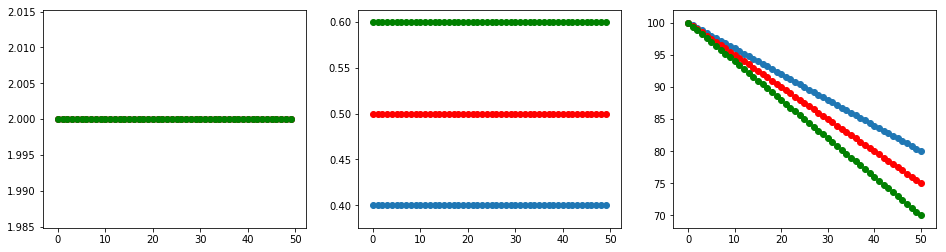

In [216]:
fig = plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(131)
ax1.scatter(range(num_step),mat[:,0])
ax1.scatter(range(num_step),mat[:,1], color="red")
ax1.scatter(range(num_step),mat[:,2], color="green")
ax2 = fig.add_subplot(132)
ax2.scatter(range(num_step),con[:,0])
ax2.scatter(range(num_step),con[:,1], color="red")
ax2.scatter(range(num_step),con[:,2], color="green")
ax3 = fig.add_subplot(133)
ax3.scatter(range(num_step+1),cpw[:,0])
ax3.scatter(range(num_step+1),cpw[:,1], color="red")
ax3.scatter(range(num_step+1),cpw[:,2], color="green")

### Proportional

In [217]:
mat, con, cpw, total, steps = simulate(num_item, 
             3, 
             num_step, 
             init_power,  
             np.array([[1/5, 0], [0, 0.5], [-1/5, 1]]),
             mechanism = PROP, a=2,b=10)
print("Valid steps: {}\nTotal utility: {}\nEfficiency: {}".format(steps, total, total/steps))

Valid steps: 150
Total utility: 75.0
Efficiency: 0.5


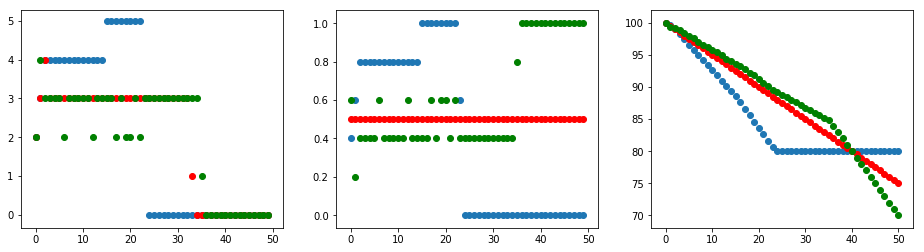

In [218]:
fig = plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(131)
ax1.scatter(range(num_step),mat[:,0])
ax1.scatter(range(num_step),mat[:,1], color="red")
ax1.scatter(range(num_step),mat[:,2], color="green")
ax2 = fig.add_subplot(132)
ax2.scatter(range(num_step),con[:,0])
ax2.scatter(range(num_step),con[:,1], color="red")
ax2.scatter(range(num_step),con[:,2], color="green")
ax3 = fig.add_subplot(133)
ax3.scatter(range(num_step+1),cpw[:,0])
ax3.scatter(range(num_step+1),cpw[:,1], color="red")
ax3.scatter(range(num_step+1),cpw[:,2], color="green")

#### Parameters

In [133]:
scores = np.zeros([99,99])
vsteps = np.zeros([99,99])
for a in range(99):
    for b in range(99):
        _, _, _, score, vstep = simulate(num_item, 
             3, 
             num_step, 
             init_power,  
             np.array([[1/5, 0], [0, 0.5], [-1/5, 1]]),
             mechanism = PROP, a=a+1,b=b+1)
        scores[a,b] = score
        vsteps[a,b] = vstep
    if a % 20 == 0: print(a)

0
20
40
60
80


In [134]:
np.argmax(scores), np.max(scores)

(10, 75.19999999999999)

In [144]:
max_idx = np.where(scores/vsteps == np.max(scores/vsteps))
(max_idx[0] + 1, max_idx[1] + 1)

(array([1]), array([11]))

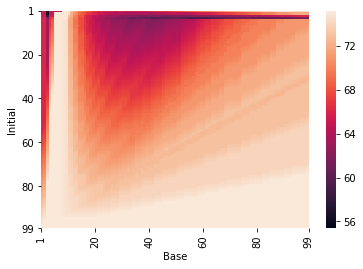

In [147]:
ax = sns.heatmap(scores)
ax.set_xlabel('Base')
ax.set_ylabel('Initial')
ax.set_xticks([0,20,40,60,80,99])
ax.set_xticklabels([1,20,40,60,80,99])
ax.set_yticks([0,20,40,60,80,99])
ax.set_yticklabels([1,20,40,60,80,99])
plt.show()

#### Best setting

In [140]:
mat, con, cpw, total, steps = simulate(num_item, 
             3, 
             num_step, 
             init_power,  
             np.array([[1/5, 0], [0, 0.5], [-1/5, 1]]),
             mechanism = PROP, a=1,b=11)
print("Valid steps: {}\nTotal utility: {}\nEfficiency: {}".format(steps, total, total/steps))

Valid steps: 150
Total utility: 75.19999999999999
Efficiency: 0.5013333333333333


In [141]:
mat[:,0]

array([1., 1., 2., 3., 3., 3., 4., 4., 4., 4., 4., 4., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

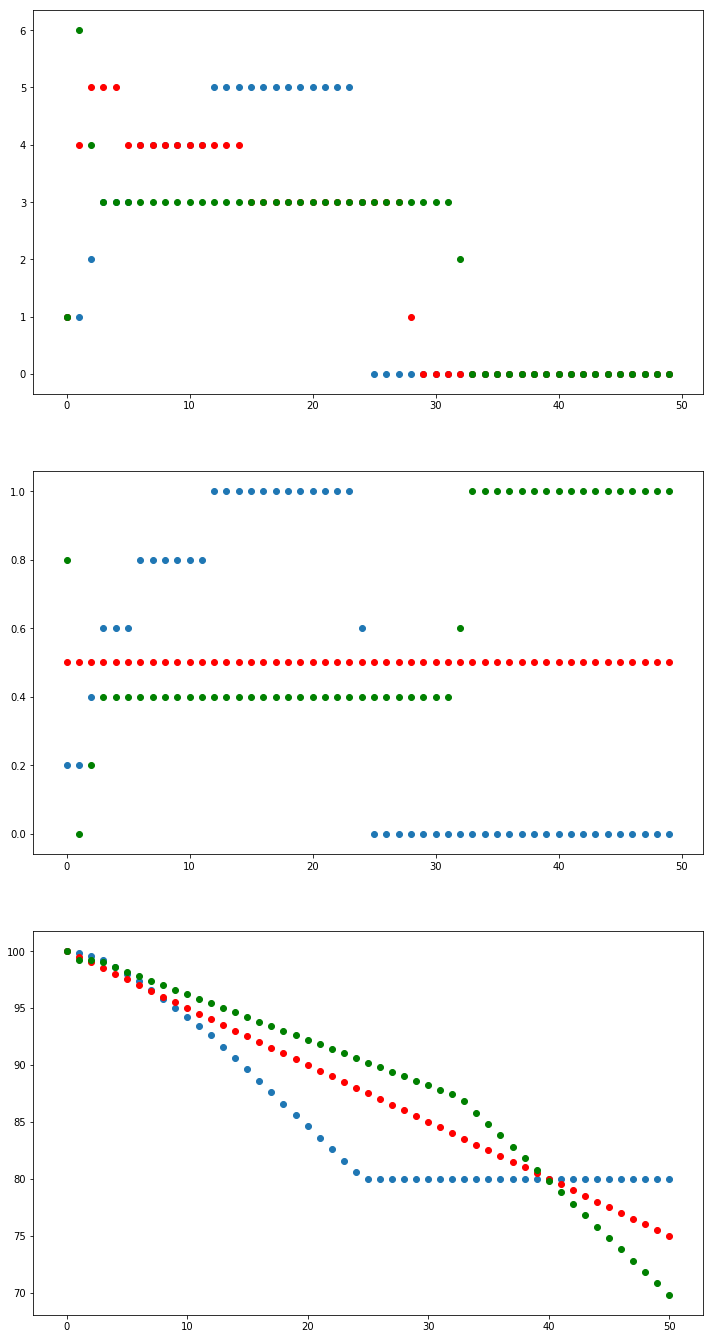

In [142]:
fig = plt.figure(figsize=(12,24))
ax1 = fig.add_subplot(311)
ax1.scatter(range(num_step),mat[:,0])
ax1.scatter(range(num_step),mat[:,1], color="red")
ax1.scatter(range(num_step),mat[:,2], color="green")
ax2 = fig.add_subplot(312)
ax2.scatter(range(num_step),con[:,0])
ax2.scatter(range(num_step),con[:,1], color="red")
ax2.scatter(range(num_step),con[:,2], color="green")
ax3 = fig.add_subplot(313)
ax3.scatter(range(num_step+1),cpw[:,0])
ax3.scatter(range(num_step+1),cpw[:,1], color="red")
ax3.scatter(range(num_step+1),cpw[:,2], color="green")

### Optimize

In [219]:
mat, con, cpw, total, steps = simulate(num_item, 
             3, 
             num_step, 
             init_power,  
             np.array([[1/5, 0], [0, 0.5], [-1/5, 1]]),
             mechanism = OPTIM)
print("Valid steps: {}\nTotal utility: {}\nEfficiency: {}".format(steps, total, total/steps))

Valid steps: 150
Total utility: 95.0
Efficiency: 0.6333333333333333


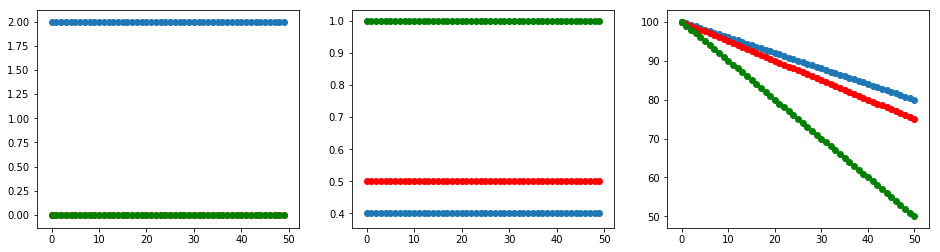

In [220]:
fig = plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(131)
ax1.scatter(range(num_step),mat[:,0])
ax1.scatter(range(num_step),mat[:,1], color="red")
ax1.scatter(range(num_step),mat[:,2], color="green")
ax2 = fig.add_subplot(132)
ax2.scatter(range(num_step),con[:,0])
ax2.scatter(range(num_step),con[:,1], color="red")
ax2.scatter(range(num_step),con[:,2], color="green")
ax3 = fig.add_subplot(133)
ax3.scatter(range(num_step+1),cpw[:,0])
ax3.scatter(range(num_step+1),cpw[:,1], color="red")
ax3.scatter(range(num_step+1),cpw[:,2], color="green")

### Randomize

In [175]:
mat, con, cpw, total, steps = simulate(num_item, 
             num_user, 
             num_step, 
             init_power,  
             funcs,
             mechanism = CONST)
print("Valid steps: {}\nTotal utility: {}\nEfficiency: {}".format(steps, total, total/steps))

Valid steps: 500
Total utility: 318.5844855841651
Efficiency: 0.6371689711683303


In [179]:
scores = np.zeros([99,99])
vsteps = np.zeros([99,99])
for a in range(99):
    for b in range(99):
        _, _, _, score, vstep = simulate(num_item, 
             num_user, 
             num_step, 
             init_power,  
             funcs,
             mechanism = PROP, a=a+1,b=b+1)
        scores[a,b] = score
        vsteps[a,b] = vstep
    if a % 20 == 0: print(a)

0
20
40
60
80


In [186]:
np.max(scores)

318.8990041455713

In [187]:
max_idx = np.where(scores/vsteps == np.max(scores/vsteps))
(max_idx[0] + 1, max_idx[1] + 1)

(array([5]), array([14]))

In [188]:
mat, con, cpw, total, steps = simulate(num_item, 
             num_user, 
             num_step, 
             init_power,  
             funcs,
             mechanism = PROP, a=5,b=14)
print("Valid steps: {}\nTotal utility: {}\nEfficiency: {}".format(steps, total, total/steps))

Valid steps: 500
Total utility: 318.8990041455713
Efficiency: 0.6377980082911426


In [199]:
mat, con, cpw, total, steps = simulate(num_item, 
             num_user, 
             num_step, 
             init_power,  
             funcs,
             mechanism = OPTIM)
print("Valid steps: {}\nTotal utility: {}\nEfficiency: {}".format(steps, total, total/steps))

Valid steps: 500
Total utility: 333.7016923931549
Efficiency: 0.6674033847863098
